In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb

/home/jiashen/env3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# XGBoost CV Framework

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

In [33]:
def xgb_cv(train,label,params,rounds,col):
    train = train.reset_index(drop=True)
    kf = KFold(n_splits=5,shuffle=False)
    i = 0
    for train_index, test_index in kf.split(train):
        i+=1
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = label[train_index],label[test_index]
        dtrain = xgb.DMatrix(X_train[col],y_train)
        dtest = xgb.DMatrix(X_test[col])
        model = xgb.train(params,dtrain,num_boost_round=rounds)
        print('training done')
        pred = model.predict(dtest)
        RMSLE = mse(np.log(y_test+1),np.log(pred+1))**0.5
        print('RMSLE: '+str(RMSLE))
        if i ==5:
            print('Check RMSE of same model in different time period')
            num_pred = round(len(y_test)/3)
            y_test1,y_test2,y_test3 = y_test[:num_pred],y_test[num_pred:num_pred*2],y_test[num_pred*2:]
            pred1,pred2,pred3 = pred[:num_pred],pred[num_pred:num_pred*2],pred[num_pred*2:]
            print(mse(np.log(y_test1+1),np.log(pred1+1))**0.5)
            print(mse(np.log(y_test2+1),np.log(pred1+2))**0.5)
            print(mse(np.log(y_test3+1),np.log(pred3+1))**0.5)

# 1. XGboost Inputs

## 1. Best Model: Original Feature Set + 0.95 Label

In [21]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

In [22]:
label = train['price_doc']*0.95+10
col = list(test.columns)[2:]

In [23]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.7958e+06	test-rmse:7.80037e+06
[50]	train-rmse:2.39694e+06	test-rmse:2.76631e+06
[100]	train-rmse:2.07912e+06	test-rmse:2.59791e+06
[150]	train-rmse:1.97156e+06	test-rmse:2.56523e+06
[200]	train-rmse:1.89038e+06	test-rmse:2.54726e+06
[250]	train-rmse:1.82037e+06	test-rmse:2.53597e+06
[300]	train-rmse:1.76422e+06	test-rmse:2.53101e+06
[350]	train-rmse:1.7127e+06	test-rmse:2.52498e+06
Performance does not improve from 372 rounds


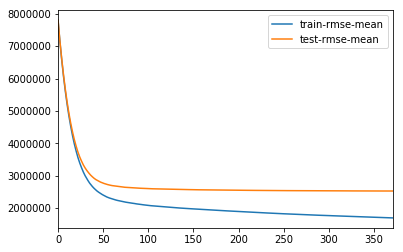

In [24]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

Re-Cross Validating Them

In [34]:
xgb_cv(train,label,params,372,col)

TRAIN: [ 6095  6096  6097 ..., 30468 30469 30470] TEST: [   0    1    2 ..., 6092 6093 6094]
training done
RMSLE: 0.590809882695
TRAIN: [    0     1     2 ..., 30468 30469 30470] TEST: [ 6095  6096  6097 ..., 12186 12187 12188]
training done
RMSLE: 0.429947470386
TRAIN: [    0     1     2 ..., 30468 30469 30470] TEST: [12189 12190 12191 ..., 18280 18281 18282]
training done
RMSLE: 0.476029789245
TRAIN: [    0     1     2 ..., 30468 30469 30470] TEST: [18283 18284 18285 ..., 24374 24375 24376]
training done
RMSLE: 0.449391124542
TRAIN: [    0     1     2 ..., 24374 24375 24376] TEST: [24377 24378 24379 ..., 30468 30469 30470]
training done
RMSLE: 0.412451758223
Check RMSE of same model in different time period
0.43429368646
0.729096407802
0.387951909708


## 2. Base Model With Subsampled Dataset and original label

In [41]:
train = pd.read_csv('train_adjusted.csv')
col = list(test.columns)[2:]
for each in col:
    if train[each].dtype == 'object':
        train[each] = pd.factorize(train[each], sort=True)[0]
        test[each]=pd.factorize(test[each], sort=True)[0]

In [47]:
dtrain = xgb.DMatrix(train[col],label)
label = train['price_doc']
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:8.36082e+06	test-rmse:8.36776e+06
[50]	train-rmse:2.27264e+06	test-rmse:2.71923e+06
[100]	train-rmse:1.91405e+06	test-rmse:2.53384e+06
[150]	train-rmse:1.78773e+06	test-rmse:2.49972e+06
[200]	train-rmse:1.70157e+06	test-rmse:2.47908e+06
[250]	train-rmse:1.63074e+06	test-rmse:2.46875e+06
[300]	train-rmse:1.57054e+06	test-rmse:2.46074e+06
[350]	train-rmse:1.51669e+06	test-rmse:2.45707e+06
[400]	train-rmse:1.46812e+06	test-rmse:2.45506e+06
[450]	train-rmse:1.42741e+06	test-rmse:2.453e+06
Performance does not improve from 450 rounds


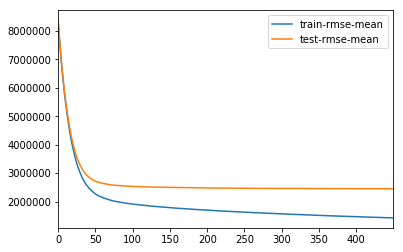

In [48]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [51]:
xgb_cv(train,label,params,len(xgb_cvalid),col)

TRAIN: [ 5853  5854  5855 ..., 29259 29260 29261] TEST: [   0    1    2 ..., 5850 5851 5852]
training done
RMSLE: 0.39423641369
TRAIN: [    0     1     2 ..., 29259 29260 29261] TEST: [ 5853  5854  5855 ..., 11703 11704 11705]
training done
RMSLE: 0.321154354061
TRAIN: [    0     1     2 ..., 29259 29260 29261] TEST: [11706 11707 11708 ..., 17555 17556 17557]
training done
RMSLE: 0.339004823352
TRAIN: [    0     1     2 ..., 29259 29260 29261] TEST: [17558 17559 17560 ..., 23407 23408 23409]
training done
RMSLE: 0.320998590207
TRAIN: [    0     1     2 ..., 23407 23408 23409] TEST: [23410 23411 23412 ..., 29259 29260 29261]
training done
RMSLE: 0.298932529875
Check RMSE of same model in different time period
0.286272398875
0.666838420045
0.286828532838
